In [5]:
#导入数据
import itertools
import warnings
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')
np.random.seed(100)
#import os
#file_dir=os.getcwd()#获取当前工作目录路径
window=2#时间窗
scale=2000#归一化参数
amount_of_features=1#特征数量
train_file='alic90_131.xls'#file_dir+'\\data\\alic\\alic90_131.xls'#读取训练集地址
test_file='alic132_136.xls'#file_dir+'\\data\\alic\\alic132_136.xls'#读取测试集地址
save_file='alic_predict_sarima.csv'#file_dir+'\\data\\alic\\alic_predict_arima.csv'#储存预测值地址

In [6]:
#读取数据，构造训练集和测试集的函数
def read_train(file_name,window,scale):
    #读取数据 
    data=pd.read_excel(file_name,header=None) 
    data=data[1]
    return data
def read_test(file_name,window,scale):
    #读取数据 
    data=pd.read_excel(file_name,header=None) 
    data=data.iloc[:,:]
    data=data[0]
    return data

In [7]:
train=read_train(train_file,window,scale)
test=read_test(test_file,window,scale)
data=pd.concat([train,test])

In [8]:
#优化，找到最小的AIC 从而得到sarima模型的参数ARIMA(p,d,q)(P,D,Q)s
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
warnings.filterwarnings("ignore") # specify to ignore warning messages
record=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            record.append([param,param_seasonal,results.aic])
        except:
            continue
#对网格搜索结果排序
(pd.DataFrame(record,columns=['ARIMA','seasonal','AIC'])).sort_values(by='AIC',ascending=True).head()

,ARIMA,seasonal,AIC
59,"(1, 1, 1)","(0, 1, 1, 12)",5648.202626
63,"(1, 1, 1)","(1, 1, 1, 12)",5648.998692
61,"(1, 1, 1)","(1, 0, 1, 12)",5719.429893
51,"(1, 1, 0)","(0, 1, 1, 12)",5722.718963
55,"(1, 1, 0)","(1, 1, 1, 12)",5724.635373


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8923      0.019     45.854      0.000       0.854       0.930
ma.L1         -0.6908      0.035    -19.719      0.000      -0.759      -0.622
ma.S.L12      -0.9196      0.012    -73.703      0.000      -0.944      -0.895
sigma2        18.1102      0.420     43.099      0.000      17.287      18.934


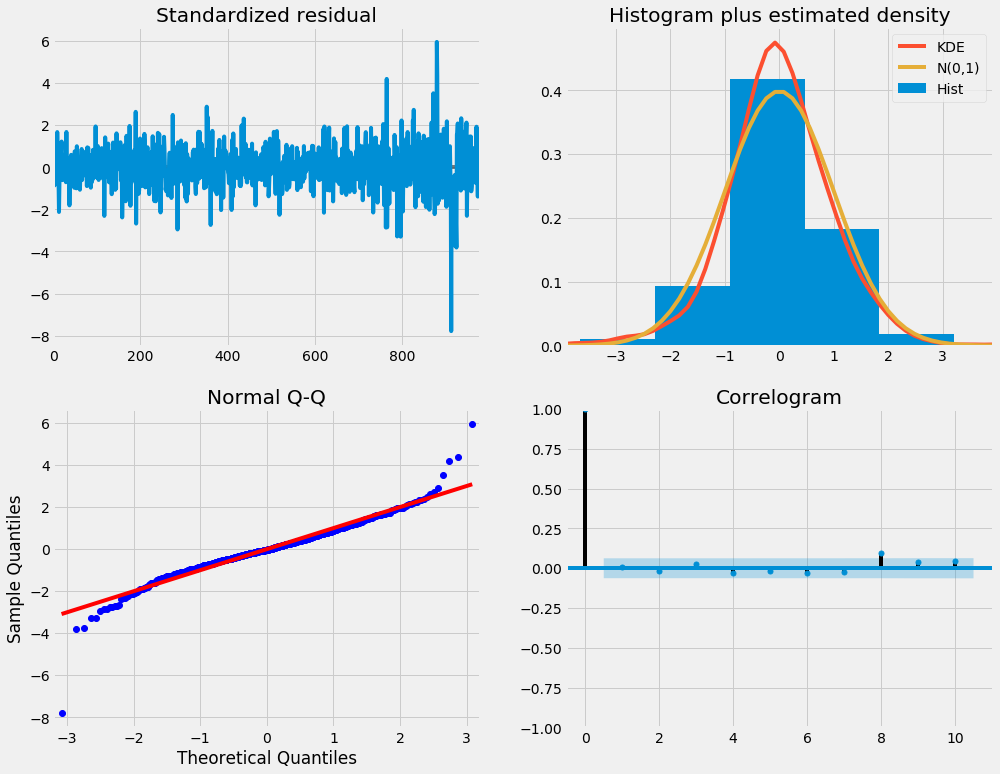

In [9]:
#SARIMA模型 
#拟合模型+检验模型 残差不能相关
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [10]:
#展示效果
pred = results.get_prediction(start=0, dynamic=False)
y_train_predict = pred.predicted_mean.values
y_train_predict=y_train_predict[20:]
y_train = train.values
y_train=y_train[20:]
#在测试集上进行预测
pred_uc = results.get_forecast(steps=len(test))  # retun out-of-sample forecast 
y_test_predict=pred_uc.predicted_mean
y_test_predict=y_test_predict.values
y_test=test.values

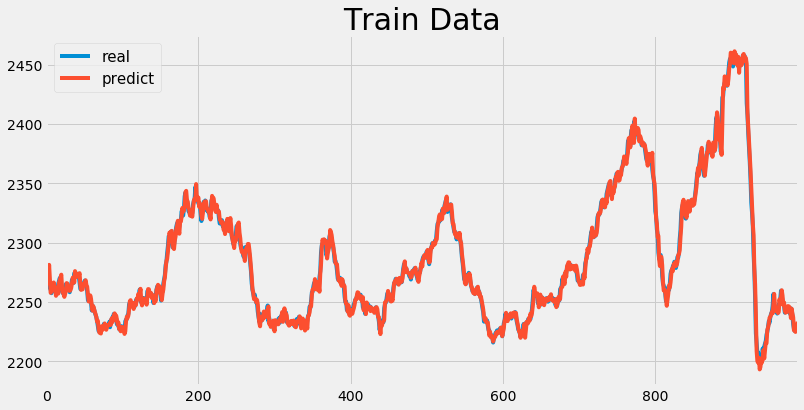

训练集上的MAE/RMSE/MAPE/涨跌准确率
3.1399932497589464
4.3053532144106
0.13682248495917934
0.5866261398176292


In [11]:
#以下函数均为对模型进行检验所用到的  精简代码的作用
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def up_down_accuracy(y_true, y_pred):
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]#实际涨跌
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]#原始涨跌
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result
#展示在训练集上的表现 
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[:,0].plot(figsize=(12,6))
draw.iloc[:,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题
plt.show()
#输出结果
print('训练集上的MAE/RMSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_train_predict, y_train))
print(np.sqrt(mean_squared_error(y_train_predict, y_train)))
print(mape(y_train_predict, y_train) )
print(up_down_accuracy(y_train_predict,y_train))


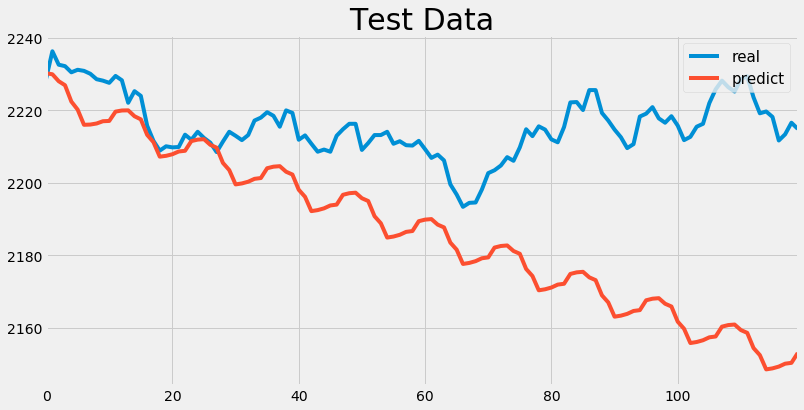

测试集上的MAE/RMSE/MAPE/涨跌准确率
28.733849139995804
36.00451185924664
1.3231899852120426
0.5462184873949579


In [12]:
#展示在测试集上的表现 
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[:,0].plot(figsize=(12,6))
draw.iloc[:,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题
plt.show()
print('测试集上的MAE/RMSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_test_predict, y_test))
print(np.sqrt(mean_squared_error(y_test_predict, y_test)))
print(mape(y_test_predict,  y_test) )
print(up_down_accuracy(y_test_predict,y_test))

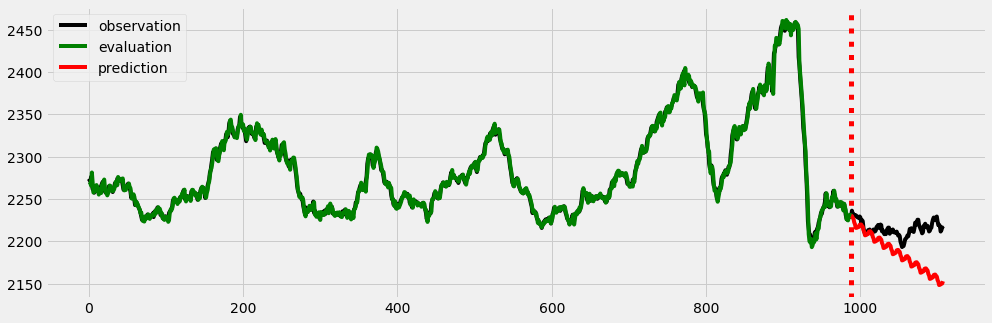

In [13]:
observed=np.hstack((y_train,y_test)) 
evaluated=y_train_predict
predicted=y_test_predict
observed_times=np.arange(len(y_train)+len(y_test))
evaluated_times=np.arange(len(y_train))
predicted_times=np.arange(len(y_train),len(y_train)+len(y_test))
plt.figure(figsize=(15, 5))
plt.axvline(len(y_train), linestyle="dotted", linewidth=5, color='r')
observed_lines = plt.plot(observed_times, observed, label="observation", color="k")
evaluated_lines = plt.plot(evaluated_times, evaluated, label="evaluation", color="g")
predicted_lines = plt.plot(predicted_times, predicted, label="prediction", color="r")

plt.legend(handles=[observed_lines[0], evaluated_lines[0], predicted_lines[0]],
         loc="upper left")
#为训练，验证，预测数据分别创建图例
plt.show()

In [14]:
#储存文件
(pd.DataFrame(y_test_predict)).to_csv(save_file)